In [1]:
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import matplotlib.pyplot as plt
import contextily as ctx

# Una exploración

En clase surgió una observación interesante: los patrones de segregación para la población hablante de lengua indígana masculina y femenina son diferentes. En este ejercicio vamos a tratar de explorar un poco más sobre el mismo tema

In [2]:
pd.set_option('display.max_colwidth', None)
diccionario_datos = pd.read_csv("./datos/diccionario_datos_ageb_urbana_08_cpv2020.csv", encoding='latin1')
diccionario_datos[diccionario_datos['Indicador'].str.contains('indígena')][['Indicador', 'Mnemónico']]

,Indicador,Mnemónico
68,Población de 3 años y más que habla alguna lengua indígena,P3YM_HLI
69,Población femenina de 3 años y más que habla alguna lengua indígena,P3YM_HLI_F
70,Población masculina de 3 años y más que habla alguna lengua indígena,P3YM_HLI_M
71,Población de 3 años y más que habla alguna lengua indígena y no habla español,P3HLINHE
72,Población femenina de 3 años y más que habla alguna lengua indígena y no habla español,P3HLINHE_F
73,Población masculina de 3 años y más que habla alguna lengua indígena y no habla español,IP3HLINHE_M
74,Población de 3 años y más que habla alguna lengua indígena y habla español,P3HLI_HE
75,Población femenina de 3 años y más que habla alguna lengua indígena y habla español,P3HLI_HE_F
76,Población masculina de 3 años y más que habla alguna lengua indígena y habla español,P3HLI_HE_M
77,Población de 5 años y más que habla alguna lengua indígena,P5_HLI


Vamos a hacer una función para poder pédir los datos más fácil, por si después queremos hacer cambios

In [3]:
def dame_agebs_variables(variables):
    cdmx = gpd.read_file("datos/agebs_cdmx_2020.zip")
    edomex = gpd.read_file("datos/agebs_edomex_2020.zip")
    limite_metropolitano = gpd.read_file("datos/limite_metropolitano.zip")
    limite_metropolitano = limite_metropolitano.to_crs(cdmx.crs)
    agebs_todas = pd.concat([cdmx, edomex])
    agebs_zmvm = sjoin(agebs_todas, limite_metropolitano)
    datos_cdmx = pd.read_csv("datos/conjunto_de_datos_ageb_urbana_09_cpv2020.zip", dtype={'ENTIDAD':str, 'MUN':str, 'LOC':str, 'AGEB':str})
    datos_edomex = pd.read_csv("datos/conjunto_de_datos_ageb_urbana_15_cpv2020.zip", dtype={'ENTIDAD':str, 'MUN':str, 'LOC':str, 'AGEB':str})
    datos_zmvm = pd.concat([datos_cdmx, datos_edomex])
    datos_zmvm = datos_zmvm.loc[datos_zmvm['NOM_LOC'] == 'Total AGEB urbana', :]
    datos_zmvm['CVEGEO'] = datos_zmvm['ENTIDAD'] + datos_zmvm['MUN'] + datos_zmvm['LOC'] + datos_zmvm['AGEB']
    datos_zmvm = datos_zmvm.loc[:, ['CVEGEO', *variables]]
    agebs_zmvm = agebs_zmvm.merge(datos_zmvm, on="CVEGEO", how="inner")
    for v in variables:
        agebs_zmvm[v] = pd.to_numeric(agebs_zmvm[v], errors='coerce')
    agebs_zmvm.dropna(subset=variables, how='any', inplace=True)
    return agebs_zmvm

In [4]:
pd.reset_option("max_colwidth")
agebs_zmvm = dame_agebs_variables(['POBTOT', 'P3YM_HLI', 'P3YM_HLI_F', 'P3YM_HLI_M', 'PHOG_IND']) 
agebs_zmvm

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,geometry,index_right,id,POBTOT,P3YM_HLI,P3YM_HLI_F,P3YM_HLI_M,PHOG_IND
0,0901000011716,09,010,0001,1716,"POLYGON ((2787237.541 816989.461, 2787288.728 ...",0,1,7042,170.0,103.0,67.0,408.0
1,0901000012150,09,010,0001,2150,"POLYGON ((2794154.458 823013.444, 2794155.774 ...",0,1,4588,26.0,14.0,12.0,54.0
2,0901000011133,09,010,0001,1133,"POLYGON ((2795690.723 820050.788, 2795684.238 ...",0,1,2203,25.0,18.0,7.0,16.0
3,0901000011307,09,010,0001,1307,"POLYGON ((2792584.475 815678.668, 2792624.325 ...",0,1,2914,86.0,68.0,18.0,4.0
4,0901000010281,09,010,0001,0281,"POLYGON ((2788845.392 823526.074, 2788840.549 ...",0,1,237,6.0,6.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5752,1512200081169,15,122,0008,1169,"POLYGON ((2817944.222 814661.498, 2818053.755 ...",0,1,3315,150.0,71.0,79.0,305.0
5754,1512500010016,15,125,0001,0016,"POLYGON ((2808318.468 857265.867, 2808312.961 ...",0,1,2686,15.0,8.0,7.0,54.0
5755,1512500010020,15,125,0001,0020,"POLYGON ((2807637.181 858200.578, 2807639.598 ...",0,1,3209,35.0,16.0,19.0,130.0
5756,1512500070054,15,125,0007,0054,"POLYGON ((2806574.677 856458.207, 2806484.183 ...",0,1,1573,11.0,7.0,4.0,29.0


## Reproduciendo el mismo ejercicio anterior

### Disimilaridad

In [5]:
from segregation.singlegroup import Dissim
dissim_total = Dissim(agebs_zmvm, group_pop_var='P3YM_HLI', total_pop_var='POBTOT')
dissim_masculino = Dissim(agebs_zmvm, group_pop_var='P3YM_HLI_M', total_pop_var='POBTOT')
dissim_femenino = Dissim(agebs_zmvm, group_pop_var='P3YM_HLI_F', total_pop_var='POBTOT')
print(f'Disimilaridad para el total de hablantes de lengua indígena: {dissim_total.statistic}')
print(f'Disimilaridad para hablantes de lengua indígena masculinos: {dissim_masculino.statistic}')
print(f'Disimilaridad para hablantes de lengua indígena femeninas: {dissim_femenino.statistic}')

Disimilaridad para el total de hablantes de lengua indígena: 0.30520942292320646
Disimilaridad para hablantes de lengua indígena masculinos: 0.31277060620535524
Disimilaridad para hablantes de lengua indígena femeninas: 0.3041271547837191


### Índices globales

In [6]:
from segregation.singlegroup import AbsoluteCentralization, Gini
grupos = ['P3YM_HLI', 'P3YM_HLI_M', 'P3YM_HLI_F']
# Centralización absoluta
for grupo in grupos:
    cent = AbsoluteCentralization(agebs_zmvm, group_pop_var=grupo, total_pop_var='POBTOT')
    aspatial_gini = Gini(agebs_zmvm, group_pop_var=grupo, total_pop_var='POBTOT')
    gen_spatialgini = Gini(agebs_zmvm, group_pop_var=grupo, total_pop_var='POBTOT', distance=2000)
    print(f'Centralización absoluta para {grupo}: {cent.statistic}')
    print(f'Gini aespacial para {grupo}: {aspatial_gini.statistic}')
    print(f'Gini generalizado para {grupo}: {gen_spatialgini.statistic}')
    


Centralización absoluta para P3YM_HLI: 0.21234964512927945
Gini aespacial para P3YM_HLI: 0.41921642039506585
Gini generalizado para P3YM_HLI: 0.28390548502500185
Centralización absoluta para P3YM_HLI_M: 0.21137714096084892
Gini aespacial para P3YM_HLI_M: 0.43012837700179
Gini generalizado para P3YM_HLI_M: 0.2885033925708532
Centralización absoluta para P3YM_HLI_F: 0.21322936085243782
Gini aespacial para P3YM_HLI_F: 0.4196339383325348
Gini generalizado para P3YM_HLI_F: 0.28016510988209653


## Índices Locales

### Location Quotient

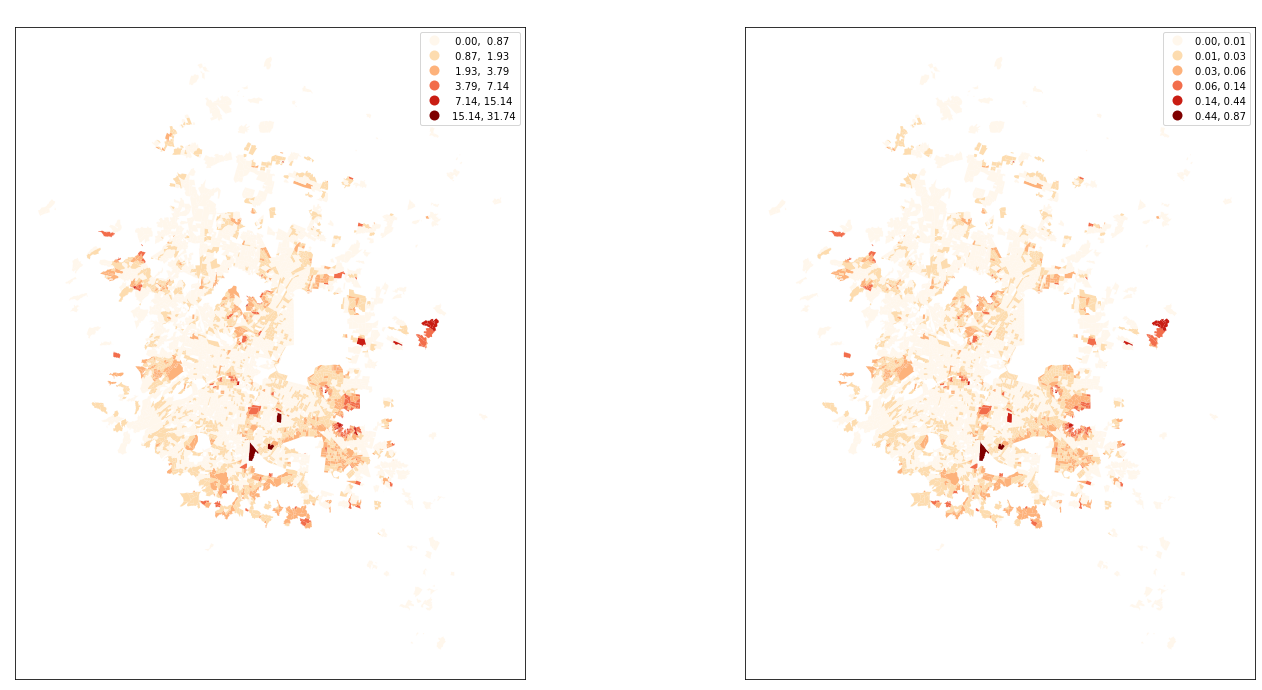

In [7]:
from segregation.local import MultiLocationQuotient
lq = MultiLocationQuotient(agebs_zmvm, ['POBTOT', 'P3YM_HLI'])
agebs_zmvm['LQ_P3YM_HLI' ] = lq.statistics[:,1]
# proporción de P3YM_HLI por habitantes
agebs_zmvm['PROP_P3YM_HLI'] = agebs_zmvm['P3YM_HLI'] / agebs_zmvm['POBTOT']
# mapas
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24,12))
ax1 = agebs_zmvm.plot(column = 'LQ_P3YM_HLI',
                     cmap = 'OrRd',
                     legend = True,
                      scheme='fisherjenks',
                      k=6,
                     ax=ax1)
ax1.set_title('Cociente de Localización de hablantes de lengua indígena', fontsize = 18, color='white')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_facecolor('white')

ax2 = agebs_zmvm.plot(column='PROP_P3YM_HLI',
                      cmap = 'OrRd',
                      legend = True,
                      scheme='fisherjenks',
                      k=6,
                      ax=ax2
                     )
ax2.set_title('Distribución de la población indígena', fontsize = 18, color='white')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_facecolor('white')

### Ahora para la población hablante de lengua indígena masculina y femenina

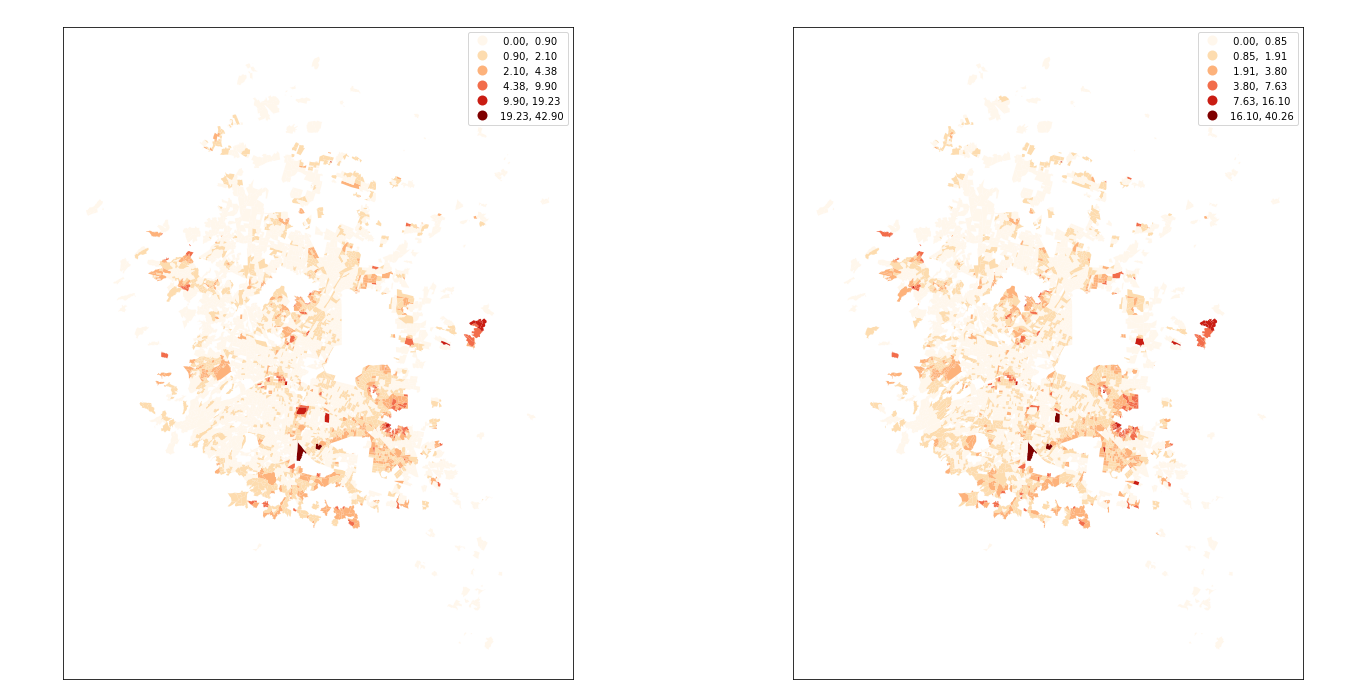

In [47]:
lq_m = MultiLocationQuotient(agebs_zmvm, ['POBTOT', 'P3YM_HLI_M'])
agebs_zmvm['LQ_P3YM_HLI_M' ] = lq_m.statistics[:,1]
lq_f = MultiLocationQuotient(agebs_zmvm, ['POBTOT', 'P3YM_HLI_F'])
agebs_zmvm['LQ_P3YM_HLI_F' ] = lq_f.statistics[:,1]
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24,12))
ax1 = agebs_zmvm.plot(column = 'LQ_P3YM_HLI_M',
                     cmap = 'OrRd',
                     legend = True,
                      scheme='fisherjenks',
                      k=6,
                     ax=ax1)
ax1.set_title('Cociente de Localización de hablantes de lengua indígena Masculina', fontsize = 18, color='white')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_facecolor('white')

ax2 = agebs_zmvm.plot(column='LQ_P3YM_HLI_F',
                      cmap = 'OrRd',
                      legend = True,
                      scheme='fisherjenks',
                      k=6,
                      ax=ax2
                     )
ax2.set_title('Cociente de Localización de hablantes de lengua indígena Femeninia', fontsize = 18, color='white')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_facecolor('white')

Son definitivamente diferentes! Comparemos ahora el Coeficiente de Localización entre ellos

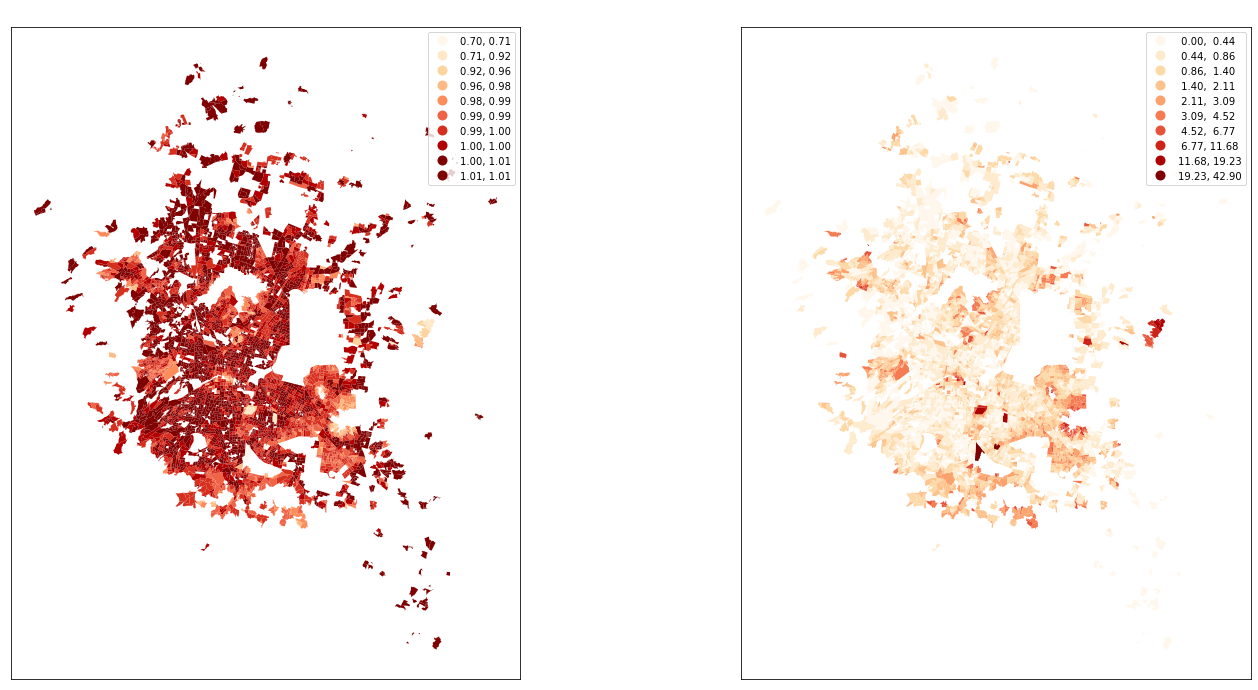

In [43]:
grupos = ['P3YM_HLI_M', 'P3YM_HLI_F']
lq = MultiLocationQuotient(agebs_zmvm, grupos)
for i, g in enumerate(grupos):
    agebs_zmvm['LQ_' + g] = lq_m.statistics[:,i]

fig, axes = plt.subplots(1, 2, figsize=(24,12))
axes = axes.ravel()
for ax, grupo in zip(axes, grupos):
    ax = agebs_zmvm.plot(column = 'LQ_' + grupo,
                     cmap = 'OrRd',
                     legend = True,
                     scheme='fisherjenks',
                     k=10,
                     ax=ax)
    ax.set_title('Cociente de Localización de ' + grupo, fontsize = 18, color='white')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_facecolor('white')

### Concentración Local de Simpson

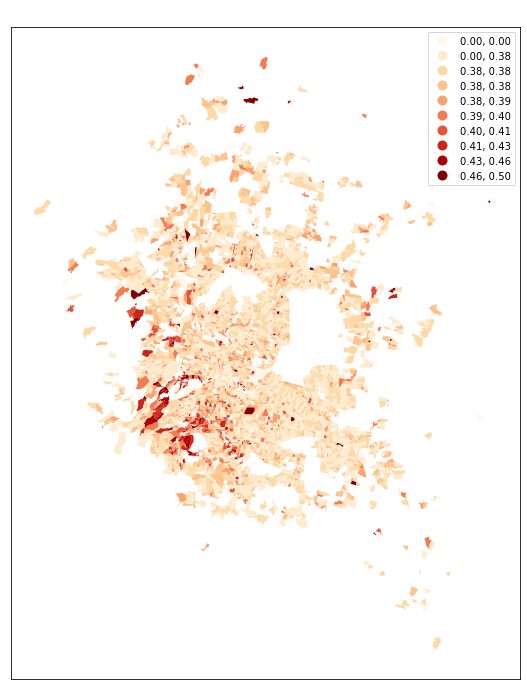

In [51]:
from segregation.local import MultiLocalSimpsonConcentration
lsc = MultiLocalSimpsonConcentration(agebs_zmvm, grupos)
agebs_zmvm['Local_Simpson_Concentration'] = lsc.statistics
fig, ax = plt.subplots(1,1, figsize=(12,12))
ax = agebs_zmvm.plot(column = 'Local_Simpson_Concentration',
                     cmap = 'OrRd',
                     legend = True,
                      scheme='fisherjenks',
                      k=10,
                     ax=ax)
ax.set_title('Concentración Local de Simpson', fontsize = 18, color='white')
ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor('white')